# (Optional) Load Data from Kaggle into Google Colab

In [10]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'aiim-emotion-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F77823%2F8553100%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240703%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240703T090247Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dc04465bd270ce3e228ee471434371bbe80f78ee95e4d36bc797b023cc9bd54dde4b4ed5cf70b099d594725687f5161c9ba30ac9d9e5f005006104d4fa5881496161efb4697ea71317dd09a4b080c9be1733f01e0ef939b3d8264ec01c3f10ea8999ad55f9e473f30ab29604f89bc687359af4c7a9afed58f827bc31344080727ced469d996f236ac2de34e7cae4b67aed0c71db1935e4af7aeb94f1354fa61fbb9c3ca3816e641ab865a5cb779734a5cc1ab5db66c4c8562f04d34106e418f32dfa87936318e7c70074b54015986197a396ca1bf68baa6574e31cc2e231e2a3db4d1db4f2012aca4cd86d7360c8f870f1b70b3dc6ee0b6c219cbfe8fc48bb81f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 18175099 bytes downloaded
Downloaded and uncompressed: aiim-emotion-classification
Data source import complete.


### Imports

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import os
from keras.utils import image_dataset_from_directory, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D,  Flatten, Dense, Dropout, BatchNormalization, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomBrightness, Rescaling, RandomTranslation, GlobalMaxPooling2D
from keras.optimizers import Adam, SGD
from keras.optimizers.schedules import ExponentialDecay
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.losses import CategoricalCrossentropy
from sklearn.metrics import f1_score, confusion_matrix, classification_report

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


# Fine-tuning Models

In [12]:
base_directory = '/kaggle/input/aiim-emotion-classification/aiim-emotion-classification/'
batch_size = 64
epochs = 70

In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np


dataset = image_dataset_from_directory(
    directory=base_directory + 'train/',
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=None,
    shuffle=True,
    seed=420,
    image_size=(100, 100))


class_names = dataset.class_names
print("Classes:", class_names)

def count_images_per_class(dataset, class_names):
    class_counts = {class_name: 0 for class_name in class_names}
    for image, label in dataset:
        class_idx = tf.argmax(label).numpy()
        class_name = class_names[class_idx]
        class_counts[class_name] += 1
    return class_counts

class_counts = count_images_per_class(dataset, class_names)
print("Number of Images in dataset per class:", class_counts)

max_count = max(class_counts.values())

# Oversampling
def balance_class(dataset, class_name_to_balance, target_count, class_names):
    images = []
    labels = []
    for image, label in dataset:
        images.append(image.numpy())
        labels.append(label.numpy())

    images = np.array(images)
    labels = np.array(labels)

    class_idx_to_balance = class_names.index(class_name_to_balance)
    class_indices = np.where(np.argmax(labels, axis=1) == class_idx_to_balance)[0]

    if len(class_indices) < target_count:
        additional_indices = np.random.choice(class_indices, target_count - len(class_indices))
        balanced_images = np.concatenate([images, images[additional_indices]])
        balanced_labels = np.concatenate([labels, labels[additional_indices]])
    else:
        balanced_images = images
        balanced_labels = labels

    return tf.data.Dataset.from_tensor_slices((balanced_images, balanced_labels))

balanced_dataset = balance_class(dataset, 'fear', max_count, class_names)
print("Number of Images in balanced dataset per class:", count_images_per_class(balanced_dataset, class_names))

# Stratified Split
def stratified_split(dataset, class_names, validation_split):
    class_datasets = {class_name: [] for class_name in class_names}

    for image, label in dataset:
        class_index = tf.argmax(label).numpy()
        class_name = class_names[class_index]
        class_datasets[class_name].append((image, label))

    train_datasets = []
    validation_datasets = []

    for class_name, images in class_datasets.items():
        np.random.seed(42)
        np.random.shuffle(images)
        val_size = int(len(images) * validation_split)
        validation_datasets.extend(images[:val_size])
        train_datasets.extend(images[val_size:])

    np.random.shuffle(train_datasets)
    np.random.shuffle(validation_datasets)

    train_images, train_labels = zip(*train_datasets)
    val_images, val_labels = zip(*validation_datasets)

    train_ds = tf.data.Dataset.from_tensor_slices((list(train_images), list(train_labels)))
    validation_ds = tf.data.Dataset.from_tensor_slices((list(val_images), list(val_labels)))

    return train_ds, validation_ds

# Split in train and validation dataset
validation_split = 0.15
dataset_size = len(balanced_dataset)
val_size = int(validation_split * dataset_size)

train_ds, validation_ds = stratified_split(balanced_dataset, class_names, validation_split)

print("Number of Images in train dataset per class:", count_images_per_class(train_ds, class_names))
print("Number of Images in validation dataset per class:", count_images_per_class(validation_ds, class_names))

# Batching
train_ds = train_ds.batch(batch_size)
validation_ds = validation_ds.batch(batch_size)

print("Train and validation dataset created und batched.")

Found 9108 files belonging to 5 classes.
Classes: ['angry', 'fear', 'happy', 'sad', 'surprise']
Number of Images in dataset per class: {'angry': 2000, 'fear': 1108, 'happy': 2000, 'sad': 2000, 'surprise': 2000}
Number of Images in balanced dataset per class: {'angry': 2000, 'fear': 2000, 'happy': 2000, 'sad': 2000, 'surprise': 2000}
Number of Images in train dataset per class: {'angry': 1700, 'fear': 1700, 'happy': 1700, 'sad': 1700, 'surprise': 1700}
Number of Images in validation dataset per class: {'angry': 300, 'fear': 300, 'happy': 300, 'sad': 300, 'surprise': 300}
Train and validation dataset created und batched.


In [15]:
!pip install keras_cv
import keras_cv
from keras.layers import GlobalAveragePooling2D
from keras_cv.layers import RandAugment, RandomCutout, RandomChoice
from keras.applications import ResNet50, ResNet50V2, Xception, EfficientNetB0, EfficientNetB4, ConvNeXtXLarge, ConvNeXtLarge

# Data Augmentation
mix_up = keras_cv.layers.MixUp()
cut_mix = keras_cv.layers.CutMix()

rand_augment_layers = keras_cv.layers.RandAugment.get_standard_policy(
    value_range=(0, 255), magnitude=0.4, magnitude_stddev=0.2,
)
rand_augment_layers = [
    layer for layer in rand_augment_layers if not isinstance(layer, keras_cv.layers.RandomColorDegeneration)
]

augmenters = [
    RandomFlip("horizontal"),
    keras_cv.layers.RandomAugmentationPipeline(
    layers=rand_augment_layers, augmentations_per_image=3
    ),
    RandomCutout(width_factor=0.2, height_factor=0.2),
    RandomChoice([cut_mix, mix_up], batchwise=True),
]

# Since the images are grayscale, we need to convert them to RGB by repeating the grayscale channel
def to_rgb(image, label):
    image = tf.image.grayscale_to_rgb(image)
    return image, label

train_ds_rgb = train_ds.map(to_rgb)
validation_ds_rgb = validation_ds.map(to_rgb)

# Create the augmenter function that processes both image and label
def create_augmenter_fn(augmenters):
    def augmenter_fn(image, label):
        inputs = {"images": image, "labels": label}
        for augmenter in augmenters:
            if isinstance(augmenter, (RandomFlip, RandomRotation)):
                inputs["images"] = augmenter(inputs["images"])
            else:
                inputs = augmenter(inputs)
        return inputs["images"], inputs["labels"]
    return augmenter_fn

augmenter_fn = create_augmenter_fn(augmenters)
train_ds_preprocessed = train_ds_rgb.map(augmenter_fn)
validation_ds_preprocessed = validation_ds_rgb

In [16]:
# Create the ConvNeXtLarge model
base_model = ConvNeXtLarge(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(5, activation='softmax')
])
model.summary()

785596384/785596384 [==============================] - 36s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_large (Functional  (None, 3, 3, 1536)        196230336 
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 5)                 7685      
                                                                 
Total params: 196238021 (748.59 MB)
Trainable params: 196238021 (748.59 MB)
Non-trainable params: 0 (0.00 Byte)
________

In [17]:
# Train the new Dense layer to fit the base_model
base_model.trainable = False

model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=4, min_lr=0.00001)

history = model.fit(
    train_ds_preprocessed,
    validation_data=validation_ds_preprocessed,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/70
133/133 [==============================] - 78s 428ms/step - loss: 1.6771 - accuracy: 0.3525 - val_loss: 0.9699 - val_accuracy: 0.6213 - lr: 0.0010
Epoch 2/70
133/133 [==============================] - 45s 336ms/step - loss: 1.5080 - accuracy: 0.4147 - val_loss: 0.9204 - val_accuracy: 0.6493 - lr: 0.0010
Epoch 3/70
133/133 [==============================] - 45s 337ms/step - loss: 1.4665 - accuracy: 0.4189 - val_loss: 0.8971 - val_accuracy: 0.6613 - lr: 0.0010
Epoch 4/70
133/133 [==============================] - 45s 336ms/step - loss: 1.4135 - accuracy: 0.4429 - val_loss: 0.8826 - val_accuracy: 0.6720 - lr: 0.0010
Epoch 5/70
133/133 [==============================] - 46s 342ms/step - loss: 1.3758 - accuracy: 0.4544 - val_loss: 0.9001 - val_accuracy: 0.6593 - lr: 0.0010
Epoch 6/70
133/133 [==============================] - 45s 339ms/step - loss: 1.3831 - accuracy: 0.4581 - val_loss: 0.8778 - val_accuracy: 0.6547 - lr: 0.0010
Epoch 7/70
133/133 [==============================] 

In [18]:
# Unfreeze the base model and train it
base_model.trainable = True
for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = False

model.compile(optimizer=Adam(1e-4),
              loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=9, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=4, min_lr=1e-7)

history_finetune = model.fit(
    train_ds_preprocessed,
    validation_data=validation_ds_preprocessed,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/70
133/133 [==============================] - 172s 827ms/step - loss: 1.2539 - accuracy: 0.5186 - val_loss: 0.6804 - val_accuracy: 0.7253 - lr: 1.0000e-04
Epoch 2/70
133/133 [==============================] - 101s 761ms/step - loss: 1.1697 - accuracy: 0.5724 - val_loss: 0.5781 - val_accuracy: 0.7800 - lr: 1.0000e-04
Epoch 3/70
133/133 [==============================] - 101s 756ms/step - loss: 1.0929 - accuracy: 0.6127 - val_loss: 0.5755 - val_accuracy: 0.7853 - lr: 1.0000e-04
Epoch 4/70
133/133 [==============================] - 100s 754ms/step - loss: 1.0216 - accuracy: 0.6560 - val_loss: 0.5086 - val_accuracy: 0.8140 - lr: 1.0000e-04
Epoch 5/70
133/133 [==============================] - 101s 756ms/step - loss: 1.0329 - accuracy: 0.6500 - val_loss: 0.4828 - val_accuracy: 0.8233 - lr: 1.0000e-04
Epoch 6/70
133/133 [==============================] - 101s 757ms/step - loss: 1.0124 - accuracy: 0.6627 - val_loss: 0.4806 - val_accuracy: 0.8293 - lr: 1.0000e-04
Epoch 7/70
133/133 [==

In [19]:
# Calculate validation F1-score
y_val_true = np.concatenate([y for x, y in validation_ds_preprocessed], axis=0)
y_val_pred = model.predict(validation_ds_preprocessed)

y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val_true, axis=1)

f1 = f1_score(y_val_true_classes, y_val_pred_classes, average='weighted')
print("F1-Score: ", f1)

24/24 [==============================] - 7s 165ms/step
F1-Score:  0.883823252891562


**Note:** Since we duplicated the images of the fear class before we split the data it is possible, that the model is trained on images that are part of the validation dataset too.

The score on the kaggle test set is **0.84**.

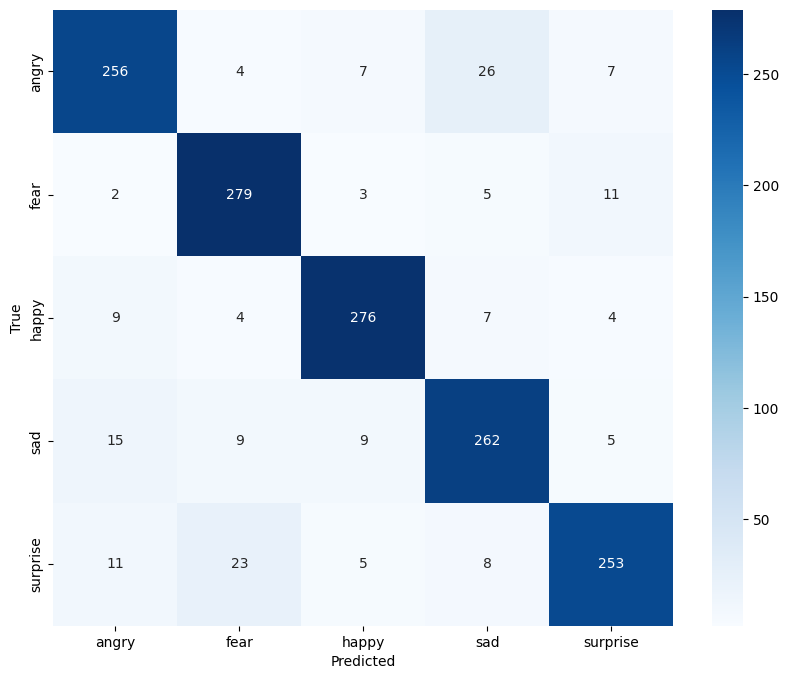

              precision    recall  f1-score   support

       angry       0.87      0.85      0.86       300
        fear       0.87      0.93      0.90       300
       happy       0.92      0.92      0.92       300
         sad       0.85      0.87      0.86       300
    surprise       0.90      0.84      0.87       300

    accuracy                           0.88      1500
   macro avg       0.88      0.88      0.88      1500
weighted avg       0.88      0.88      0.88      1500


In [20]:
# Confusion Matrix and Classification Report
cm = confusion_matrix(y_val_true_classes, y_val_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_val_true_classes, y_val_pred_classes, target_names=class_names))


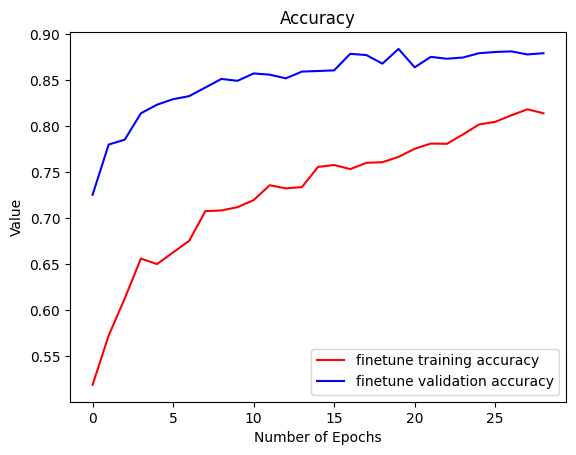

In [21]:
# Plot the loss and accuracy curves for training and validation
plt.plot(history_finetune.history['accuracy'], color='r', label="finetune training accuracy")
plt.plot(history_finetune.history['val_accuracy'], color='b', label="finetune validation accuracy")
plt.title("Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

# Create Submission

In [23]:
file_names = []
images = []
test_directory = base_directory + 'test/'

for filename in os.listdir(test_directory):
    if filename.endswith(".jpg"):
        img_path = os.path.join(test_directory, filename)
        img = load_img(img_path, target_size=(100, 100), color_mode='grayscale', interpolation='bilinear')

        img = tf.convert_to_tensor(img, dtype=tf.float32)

        img = tf.expand_dims(img, axis=-1)

        img_array = tf.image.grayscale_to_rgb(img)

        images.append(img_array)
        file_names.append(filename)

images_array = np.array(images)


y_test = model.predict(images_array)
y_pred_indices = np.argmax(y_test, axis=1)
y_pred_labels = [class_names[idx] for idx in y_pred_indices]

df = pd.DataFrame({
    'Id': file_names,
    'emotions': y_pred_labels
})

df.to_csv('./submission.csv', index=False)

75/75 [==============================] - 7s 87ms/step
